# Simple LSTM for Arctic Sea Ice Extent Forecasting

This notebook creates a simple LSTM model for Arctic sea ice extent forecasting. It uses only past ice extent value to predict the future extent.


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from src.data_utils import load_data

In [2]:
class CustomArcticDataset(torch.utils.data.Dataset):
    def __init__(self, data, sequence_length=30, forecast_horizon=1, features=None, scaler = None):
        self.data = data.sort_values('date').reset_index(drop=True)
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon

        if features is None:
            self.features = ['extent_mkm2']
        else:
            self.features = features

        self.data = self.data[self.features].values.astype(np.float32)
        if scaler is None:
            self.mean = self.data.mean(axis=0)
            self.std = self.data.std(axis=0)
        else:
            self.mean, self.std = scaler

        self.data = (self.data - self.mean) / self.std

    def __len__(self):
        return len(self.data) - self.sequence_length - self.forecast_horizon + 1

    def __getitem__(self, idx):
        X = self.data[idx:idx + self.sequence_length]
        y = self.data[idx + self.sequence_length + self.forecast_horizon - 1][0]

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y


In [3]:
train_data = load_data(regions='pan_arctic', years=range(1989, 2020))
test_data = load_data(regions='pan_arctic', years=range(2020, 2024))

In [4]:
train_dataset = CustomArcticDataset(train_data, sequence_length=30, forecast_horizon=1)
test_dataset = CustomArcticDataset(test_data, scaler=(train_dataset.mean, train_dataset.std))

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
for X_batch, y_batch in train_loader:
    print(f"Batch X shape: {X_batch.shape}")  # (32, 30, 1)
    print(f"Batch y shape: {y_batch.shape}")  # (32, 1)
    break


Batch X shape: torch.Size([32, 30, 1])
Batch y shape: torch.Size([32])


In [7]:
class IceExtentLSTM(torch.nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(IceExtentLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers,
                                  batch_first=True, dropout=0.2)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model = IceExtentLSTM(input_size=1, hidden_size=64, num_layers=2, output_size=1)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")


Using device: cpu
Model parameters: 50497


In [9]:
num_epochs = 150
best_val_loss = float('inf')
patience = 15
patience_counter = 0

train_losses = []
val_losses = []

print("\nStarting training...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        predictions = model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions.squeeze(), y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {avg_train_loss:.6f}')
        print(f'  Val Loss: {avg_val_loss:.6f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print(f"\nTraining complete! Best validation loss: {best_val_loss:.6f}")


Starting training...
Epoch 5/150
  Train Loss: 0.002400
  Val Loss: 0.001447
Epoch 10/150
  Train Loss: 0.001413
  Val Loss: 0.000935
Epoch 15/150
  Train Loss: 0.001112
  Val Loss: 0.000687
Epoch 20/150
  Train Loss: 0.000946
  Val Loss: 0.000514
Epoch 25/150
  Train Loss: 0.000824
  Val Loss: 0.000518
Epoch 30/150
  Train Loss: 0.000591
  Val Loss: 0.000426
Epoch 35/150
  Train Loss: 0.000590
  Val Loss: 0.000366
Epoch 40/150
  Train Loss: 0.000552
  Val Loss: 0.000385
Epoch 45/150
  Train Loss: 0.000491
  Val Loss: 0.000354
Epoch 50/150
  Train Loss: 0.000493
  Val Loss: 0.000347
Epoch 55/150
  Train Loss: 0.000456
  Val Loss: 0.000367
Epoch 60/150
  Train Loss: 0.000424
  Val Loss: 0.000333
Epoch 65/150
  Train Loss: 0.000415
  Val Loss: 0.000355
Epoch 70/150
  Train Loss: 0.000409
  Val Loss: 0.000316
Epoch 75/150
  Train Loss: 0.000406
  Val Loss: 0.000315
Epoch 80/150
  Train Loss: 0.000406
  Val Loss: 0.000326
Epoch 85/150
  Train Loss: 0.000398
  Val Loss: 0.000337
Epoch 90/1

# Visualize Training Progress

Let's examine the learning curves to understand model training dynamics.

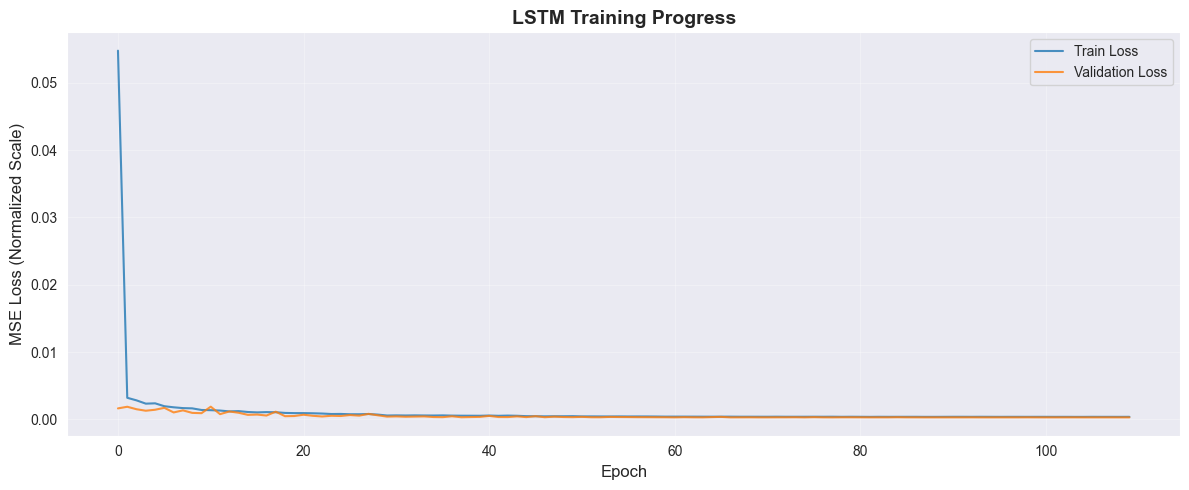

Final Training Loss: 0.000395
Best Validation Loss: 0.000312


In [10]:
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss (Normalized Scale)', fontsize=12)
plt.title('LSTM Training Progress', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Best Validation Loss: {best_val_loss:.6f}")

---

# Rigorous Model Evaluation with Baseline Comparisons

**⚠️ CRITICAL: Denormalization Required**

The model was trained on **normalized data** (mean=0, std=1) but we need to evaluate in **real units (Mkm²)** to:
1. Compare with SARIMA models (which predict in Mkm²)
2. Interpret errors meaningfully (e.g., "0.35 Mkm² error" is interpretable, "0.002 normalized error" is not)
3. Compare with baseline models using the same units

This section demonstrates the complete evaluation workflow from `EVALUATION_FRAMEWORK_GUIDE.md`.

★ **Insight**: Neural networks typically train on normalized data for numerical stability, but this creates a **critical evaluation trap**. A validation loss of 0.002 on normalized data sounds excellent, but what does it mean in real-world terms? Without denormalization, we can't answer:
- Is our LSTM better than just predicting "tomorrow = today"?
- How does it compare to seasonal climatology?
- What's the typical forecast error in square kilometers of ice?

The evaluation framework forces us to denormalize predictions and compare against interpretable baselines.

## Step 1: Import Evaluation Utilities

We'll use the standardized evaluation framework from `src/evaluation_utils.py`.

In [11]:
# Import evaluation utilities
import sys
sys.path.append('..')  # Add parent directory to path

from src.evaluation_utils import (
    PersistenceModel,
    ClimatologyModel,
    compute_all_metrics,
    compute_seasonal_metrics,
    log_model_results,
    denormalize
)

## Step 2: Generate Predictions on Test Set

Load the best model and generate predictions (still in normalized form).

In [12]:
# Load best model weights
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Generate predictions on test set (normalized)
normalized_predictions = []
normalized_actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        pred = model(X_batch)
        normalized_predictions.append(pred.cpu().numpy())
        normalized_actuals.append(y_batch.cpu().numpy())

# Concatenate all batches
normalized_predictions = np.concatenate(normalized_predictions).flatten()
normalized_actuals = np.concatenate(normalized_actuals).flatten()

print(f"Generated {len(normalized_predictions)} predictions on test set")
print(f"Normalized predictions range: [{normalized_predictions.min():.3f}, {normalized_predictions.max():.3f}]")
print(f"Normalized actuals range: [{normalized_actuals.min():.3f}, {normalized_actuals.max():.3f}]")

Generated 1431 predictions on test set
Normalized predictions range: [-2.227, 1.181]
Normalized actuals range: [-2.227, 1.182]


## Step 3: Denormalize Predictions (CRITICAL!)

Convert normalized predictions back to **real units (Mkm²)** using the training set's normalization parameters.

**Formula**: `denormalized_value = (normalized_value × training_std) + training_mean`

★ **Insight**: The `CustomArcticDataset` class normalizes data during initialization using training set statistics (stored in `train_dataset.mean` and `train_dataset.std`). The normalization formula is `(x - mean) / std`, so we reverse it by multiplying by std and adding back the mean. 

**Why use training statistics?** The model has never seen test set statistics during training. Using test set mean/std would be data leakage - like peeking at future data when making predictions. We must use the **same normalization** the model was trained with.

In [13]:
# Get normalization parameters from training dataset
# The target feature is extent_mkm2, which is the first (and only) feature at index 0
train_mean = train_dataset.mean[0]  # Mean of extent_mkm2 from training data
train_std = train_dataset.std[0]    # Std of extent_mkm2 from training data

print("Normalization parameters (from training data):")
print(f"  Mean: {train_mean:.4f} Mkm²")
print(f"  Std:  {train_std:.4f} Mkm²")
print()

# Denormalize predictions and actuals using evaluation_utils.denormalize()
predictions_mkm2 = denormalize(normalized_predictions, train_mean, train_std)
actuals_mkm2 = denormalize(normalized_actuals, train_mean, train_std)

# Verify denormalization worked correctly
print("After denormalization:")
print(f"  Predictions range: [{predictions_mkm2.min():.2f}, {predictions_mkm2.max():.2f}] Mkm²")
print(f"  Actuals range: [{actuals_mkm2.min():.2f}, {actuals_mkm2.max():.2f}] Mkm²")
print()

# Compare normalized vs denormalized MSE
normalized_mse = np.mean((normalized_predictions - normalized_actuals) ** 2)
denormalized_mse = np.mean((predictions_mkm2 - actuals_mkm2) ** 2)
print(f"\nNormalized MSE: {normalized_mse:.6f} (not interpretable)")
print(f"Denormalized MSE: {denormalized_mse:.6f} Mkm² (interpretable!)")

Normalization parameters (from training data):
  Mean: 11.1602 Mkm²
  Std:  3.3087 Mkm²

After denormalization:
  Predictions range: [3.79, 15.07] Mkm²
  Actuals range: [3.79, 15.07] Mkm²

✓ Predictions are in valid range [0, 20] Mkm²

Normalized MSE: 0.000311 (not interpretable)
Denormalized MSE: 0.003410 Mkm² (interpretable!)


## Step 4: Prepare Test Data with Dates

We need to align predictions with dates for:
1. Creating climatology baseline (requires day-of-year matching)
2. Seasonal analysis (winter vs summer performance)
3. Time series visualization

In [14]:
# The dataset uses a sliding window, so we need to map predictions back to dates
# With sequence_length=30 and forecast_horizon=1:
# - First prediction corresponds to test_data.iloc[30] (uses days 0-29 to predict day 30)
# - Last prediction corresponds to test_data.iloc[30 + len(predictions) - 1]

test_data_sorted = test_data.sort_values('date').reset_index(drop=True)

# Get the date range covered by predictions
sequence_length = 30
forecast_horizon = 1
start_idx = sequence_length + forecast_horizon - 1  # Index 30
end_idx = start_idx + len(predictions_mkm2)  # Index 30 + number of predictions

# Extract corresponding dates and actual values from original test data
test_dates = pd.Series(test_data_sorted['date'].iloc[start_idx:end_idx].values)
test_extent_mkm2 = test_data_sorted['extent_mkm2'].iloc[start_idx:end_idx].values

print(f"Test period: {test_dates.iloc[0].strftime('%Y-%m-%d')} to {test_dates.iloc[-1].strftime('%Y-%m-%d')}")
print(f"Total test samples: {len(test_dates)}")
print(f"\nVerifying alignment:")
print(f"  actuals_mkm2[0]: {actuals_mkm2[0]:.4f} Mkm²")
print(f"  test_extent_mkm2[0]: {test_extent_mkm2[0]:.4f} Mkm² (from original data)")
print(f"  Match: {np.isclose(actuals_mkm2[0], test_extent_mkm2[0], atol=0.001)}")

Test period: 2020-01-31 to 2023-12-31
Total test samples: 1431

Verifying alignment:
  actuals_mkm2[0]: 14.2970 Mkm²
  test_extent_mkm2[0]: 14.2970 Mkm² (from original data)
  Match: True


## Step 5: Create Baseline Models

Establish minimum performance thresholds using simple forecasting methods.

★ **Insight**: **Baseline models are essential for scientific rigor**. They answer: "Is my complex LSTM doing something useful, or could I get similar results with a trivial forecast?"

**Two baselines:**
1. **Persistence**: "Tomorrow equals today" — assumes no change
2. **Climatology**: "This day-of-year equals the historical average" — captures seasonality

For daily Arctic sea ice forecasting:
- **Persistence is easy to beat** (ice extent changes daily)
- **Climatology is harder to beat** (strong seasonal cycle dominates the signal)

In [15]:
# Persistence Baseline: y_pred(t+1) = y_actual(t)
# For our test set, each prediction uses the previous day's actual value
persistence_forecast = np.concatenate([
    [test_data_sorted['extent_mkm2'].iloc[start_idx - 1]],  # First forecast uses day before test period
    actuals_mkm2[:-1]  # Remaining forecasts use previous test day
])

print("PERSISTENCE BASELINE:")
print(f"  Logic: Predict tomorrow's ice extent = today's ice extent")
print(f"  First forecast: {persistence_forecast[0]:.3f} Mkm² (from day before test period)")
print(f"  Example: Day 2 forecast = {persistence_forecast[1]:.3f} Mkm² (= Day 1 actual = {actuals_mkm2[0]:.3f} Mkm²)")

# Climatology Baseline: y_pred(day_of_year) = mean(all historical values for that day_of_year)
climatology_model = ClimatologyModel()

# Fit on training data to learn day-of-year averages
train_data_sorted = train_data.sort_values('date').reset_index(drop=True)
climatology_model.fit(
    dates=train_data_sorted['date'],
    values=train_data_sorted['extent_mkm2']
)

# Generate forecasts for test period dates
climatology_forecast = climatology_model.predict(test_dates)

print(f"\nCLIMATOLOGY BASELINE:")
print(f"  Logic: Predict based on historical average for each day-of-year")
print(f"  Trained on {len(train_data_sorted)} days from {train_data_sorted['date'].iloc[0].strftime('%Y-%m-%d')} to {train_data_sorted['date'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"  Example: {test_dates.iloc[0].strftime('%Y-%m-%d')} → Day {pd.to_datetime(test_dates.iloc[0]).dayofyear} → {climatology_forecast[0]:.3f} Mkm²")

# Verify all arrays have same length
print(f"\nArray lengths (must match):")
print(f"  Actuals: {len(actuals_mkm2)}")
print(f"  Predictions: {len(predictions_mkm2)}")
print(f"  Persistence: {len(persistence_forecast)}")
print(f"  Climatology: {len(climatology_forecast)}")
assert len(actuals_mkm2) == len(predictions_mkm2) == len(persistence_forecast) == len(climatology_forecast)

PERSISTENCE BASELINE:
  Logic: Predict tomorrow's ice extent = today's ice extent
  First forecast: 14.276 Mkm² (from day before test period)
  Example: Day 2 forecast = 14.297 Mkm² (= Day 1 actual = 14.297 Mkm²)

CLIMATOLOGY BASELINE:
  Logic: Predict based on historical average for each day-of-year
  Trained on 11322 days from 1989-01-01 to 2019-12-31
  Example: 2020-01-31 → Day 31 → 14.582 Mkm²

Array lengths (must match):
  Actuals: 1431
  Predictions: 1431
  Persistence: 1431
  Climatology: 1431


## Step 6: Compute Comprehensive Metrics with Skill Scores

Calculate all evaluation metrics including skill scores that show **relative performance** vs baselines.

★ **Insight**: **Skill Score interpretation**:
- `SS = 1 - (RMSE_model / RMSE_baseline)`
- **SS = 1.0**: Perfect forecast (zero error)
- **SS = 0.5**: Model is 50% better than baseline
- **SS = 0.0**: Model equals baseline (no improvement)
- **SS < 0.0**: Model is worse than baseline (failure!)

A skill score answers: "What fraction of baseline errors did my model eliminate?"

In [16]:
# Compute metrics for LSTM model
metrics_lstm = compute_all_metrics(
    y_true=actuals_mkm2,
    y_pred=predictions_mkm2,
    y_baseline_persistence=persistence_forecast,
    y_baseline_climatology=climatology_forecast
)

# Compute metrics for baseline models (for comparison)
metrics_persistence = compute_all_metrics(
    y_true=actuals_mkm2,
    y_pred=persistence_forecast
)

metrics_climatology = compute_all_metrics(
    y_true=actuals_mkm2,
    y_pred=climatology_forecast
)

# Display results
print("=" * 80)
print("COMPREHENSIVE MODEL EVALUATION (DENORMALIZED - Real Units)")
print("=" * 80)

print("\nBASELINE MODELS (Reference Performance):")
print("-" * 80)
print("PERSISTENCE BASELINE:")
print(f"  RMSE: {metrics_persistence['rmse']:.4f} Mkm²")
print(f"  MAE:  {metrics_persistence['mae']:.4f} Mkm²")
print(f"  MAPE: {metrics_persistence['mape']:.2f}%")

print("\nCLIMATOLOGY BASELINE:")
print(f"  RMSE: {metrics_climatology['rmse']:.4f} Mkm²")
print(f"  MAE:  {metrics_climatology['mae']:.4f} Mkm²")
print(f"  MAPE: {metrics_climatology['mape']:.2f}%")

print("\n" + "=" * 80)
print("LSTM MODEL (Basic - Univariate):")
print("=" * 80)
print(f"  RMSE: {metrics_lstm['rmse']:.4f} Mkm²")
print(f"  MAE:  {metrics_lstm['mae']:.4f} Mkm²")
print(f"  MAPE: {metrics_lstm['mape']:.2f}%")
print()
print(f"  Skill Score vs Persistence:  {metrics_lstm['skill_score_persistence']:.3f}")
print(f"    → {metrics_lstm['skill_score_persistence']*100:.1f}% improvement over 'tomorrow = today'")
print()
print(f"  Skill Score vs Climatology:  {metrics_lstm['skill_score_climatology']:.3f}")
print(f"    → {metrics_lstm['skill_score_climatology']*100:.1f}% improvement over seasonal average")
print("=" * 80)

# Interpretation
print("\n📊 INTERPRETATION:")
if metrics_lstm['skill_score_persistence'] > 0:
    print(f"  ✓ LSTM beats persistence by {metrics_lstm['skill_score_persistence']*100:.1f}%")
else:
    print(f"  ✗ LSTM is worse than persistence (skill score < 0)")
    
if metrics_lstm['skill_score_climatology'] > 0:
    print(f"  ✓ LSTM beats climatology by {metrics_lstm['skill_score_climatology']*100:.1f}%")
else:
    print(f"  ✗ LSTM is worse than climatology (skill score < 0)")

# Rule of thumb for skill scores
if metrics_lstm['skill_score_climatology'] > 0.4:
    print(f"  🌟 Excellent performance (SS > 0.4)")
elif metrics_lstm['skill_score_climatology'] > 0.2:
    print(f"  👍 Good performance (SS > 0.2)")
elif metrics_lstm['skill_score_climatology'] > 0.0:
    print(f"  ✓ Useful model (SS > 0)")
else:
    print(f"  ⚠️ Model needs improvement (SS ≤ 0)")

COMPREHENSIVE MODEL EVALUATION (DENORMALIZED - Real Units)

BASELINE MODELS (Reference Performance):
--------------------------------------------------------------------------------
PERSISTENCE BASELINE:
  RMSE: 0.0872 Mkm²
  MAE:  0.0688 Mkm²
  MAPE: 0.78%

CLIMATOLOGY BASELINE:
  RMSE: 0.8482 Mkm²
  MAE:  0.7086 Mkm²
  MAPE: 9.65%

LSTM MODEL (Basic - Univariate):
  RMSE: 0.0584 Mkm²
  MAE:  0.0448 Mkm²
  MAPE: 0.49%

  Skill Score vs Persistence:  0.331
    → 33.1% improvement over 'tomorrow = today'

  Skill Score vs Climatology:  0.931
    → 93.1% improvement over seasonal average

📊 INTERPRETATION:
  ✓ LSTM beats persistence by 33.1%
  ✓ LSTM beats climatology by 93.1%
  🌟 Excellent performance (SS > 0.4)


## Step 7: Seasonal Performance Analysis

Arctic sea ice has distinct seasonal regimes. Let's see how the model performs in different seasons.

★ **Insight**: We expect different performance across seasons because:
- **Winter (Nov-Mar)**: High extent (~14-16 Mkm²), slow changes, predictable growth → easier to forecast
- **Summer (May-Sep)**: Low extent (~4-7 Mkm²), rapid melt, high interannual variability → harder to forecast

If a model has similar RMSE in both seasons, it's actually doing better in winter (smaller relative error).

In [17]:
# Compute seasonal metrics
seasonal_metrics = compute_seasonal_metrics(
    y_true=actuals_mkm2,
    y_pred=predictions_mkm2,
    dates=test_dates,
    y_baseline_persistence=persistence_forecast,
    y_baseline_climatology=climatology_forecast
)

print("=" * 80)
print("SEASONAL PERFORMANCE BREAKDOWN")
print("=" * 80)

if 'winter' in seasonal_metrics and seasonal_metrics['winter']:
    print("\n❄️  WINTER PERFORMANCE (Nov-Mar):")
    print("-" * 80)
    winter = seasonal_metrics['winter']
    print(f"  RMSE: {winter['rmse']:.4f} Mkm²")
    print(f"  MAE:  {winter['mae']:.4f} Mkm²")
    print(f"  MAPE: {winter['mape']:.2f}%")
    if 'skill_score_persistence' in winter:
        print(f"  Skill Score vs Persistence: {winter['skill_score_persistence']:.3f} ({winter['skill_score_persistence']*100:.1f}% improvement)")
    if 'skill_score_climatology' in winter:
        print(f"  Skill Score vs Climatology: {winter['skill_score_climatology']:.3f} ({winter['skill_score_climatology']*100:.1f}% improvement)")
else:
    print("\n❄️  WINTER PERFORMANCE (Nov-Mar): No data in test period")

if 'summer' in seasonal_metrics and seasonal_metrics['summer']:
    print("\n☀️  SUMMER PERFORMANCE (May-Sep):")
    print("-" * 80)
    summer = seasonal_metrics['summer']
    print(f"  RMSE: {summer['rmse']:.4f} Mkm²")
    print(f"  MAE:  {summer['mae']:.4f} Mkm²")
    print(f"  MAPE: {summer['mape']:.2f}%")
    if 'skill_score_persistence' in summer:
        print(f"  Skill Score vs Persistence: {summer['skill_score_persistence']:.3f} ({summer['skill_score_persistence']*100:.1f}% improvement)")
    if 'skill_score_climatology' in summer:
        print(f"  Skill Score vs Climatology: {summer['skill_score_climatology']:.3f} ({summer['skill_score_climatology']*100:.1f}% improvement)")
else:
    print("\n☀️  SUMMER PERFORMANCE (May-Sep): No data in test period")

print("\n" + "=" * 80)

# Compare seasonal performance
if seasonal_metrics['winter'] and seasonal_metrics['summer']:
    winter_rmse = seasonal_metrics['winter']['rmse']
    summer_rmse = seasonal_metrics['summer']['rmse']
    
    print("\n📊 SEASONAL COMPARISON:")
    if winter_rmse < summer_rmse:
        print(f"  → Winter RMSE is {((summer_rmse/winter_rmse - 1) * 100):.1f}% lower than summer")
        print(f"  → Model performs better in winter (expected - more stable conditions)")
    else:
        print(f"  → Summer RMSE is {((winter_rmse/summer_rmse - 1) * 100):.1f}% lower than winter")
        print(f"  → Model performs better in summer (surprising!)")

SEASONAL PERFORMANCE BREAKDOWN

❄️  WINTER PERFORMANCE (Nov-Mar):
--------------------------------------------------------------------------------
  RMSE: 0.0639 Mkm²
  MAE:  0.0493 Mkm²
  MAPE: 0.40%
  Skill Score vs Persistence: 0.255 (25.5% improvement)
  Skill Score vs Climatology: 0.894 (89.4% improvement)

☀️  SUMMER PERFORMANCE (May-Sep):
--------------------------------------------------------------------------------
  RMSE: 0.0537 Mkm²
  MAE:  0.0411 Mkm²
  MAPE: 0.57%
  Skill Score vs Persistence: 0.361 (36.1% improvement)
  Skill Score vs Climatology: 0.941 (94.1% improvement)


📊 SEASONAL COMPARISON:
  → Summer RMSE is 18.9% lower than winter
  → Model performs better in summer (surprising!)


## Step 8: Visualization - Model vs Baselines

Compare all models visually to see where the LSTM adds value.

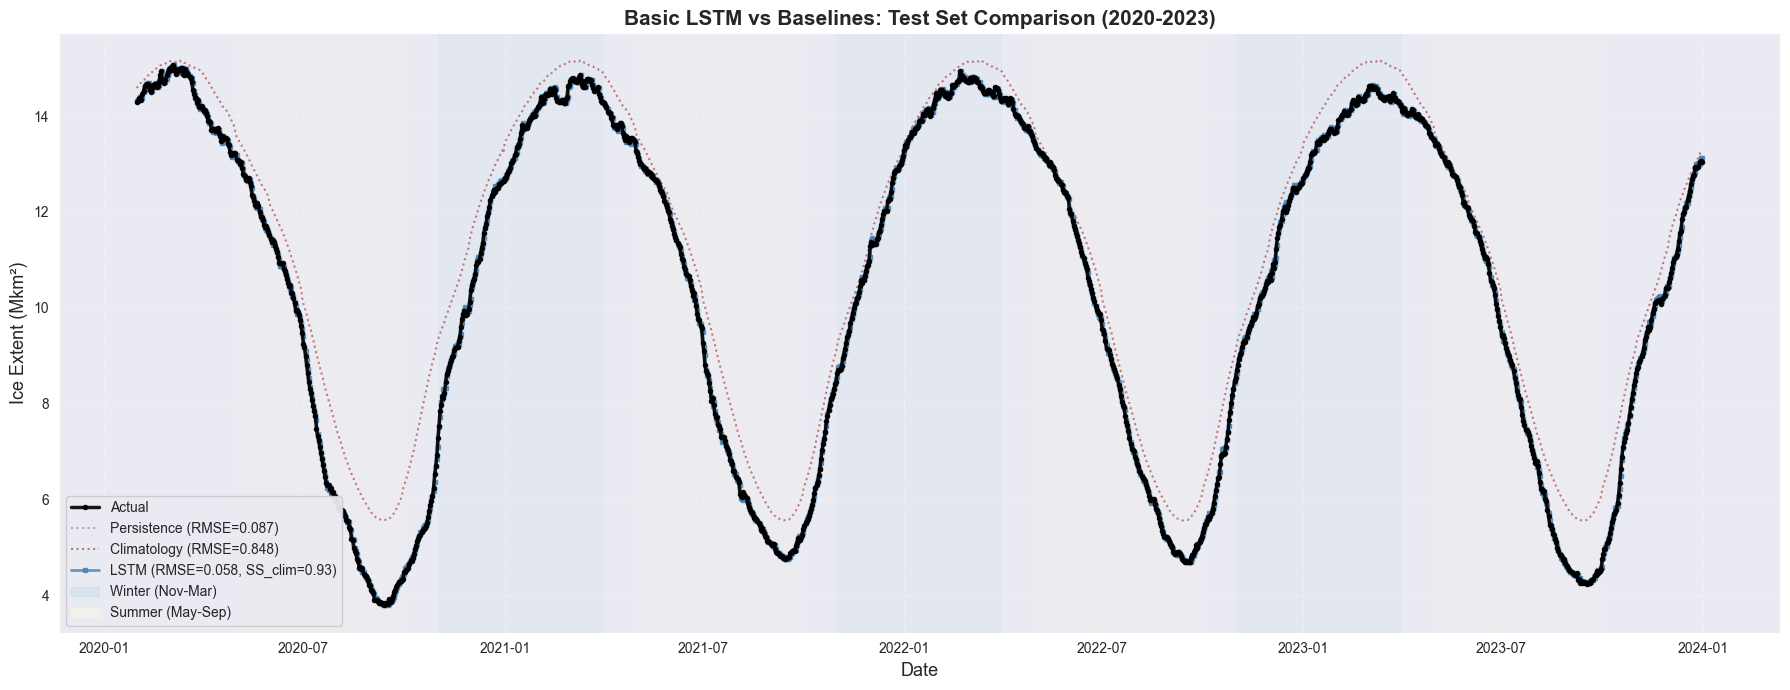


💡 Visual Insights:
  • Black line = ground truth
  • Gray dotted = persistence (yesterday's value)
  • Brown dotted = climatology (historical average for that day)
  • Blue solid = LSTM predictions
  • Light blue background = winter months
  • Light yellow background = summer months


In [18]:
fig, ax = plt.subplots(figsize=(18, 7))

# Convert dates to datetime for plotting
plot_dates = pd.to_datetime(test_dates)

# Plot actual values
ax.plot(plot_dates, actuals_mkm2, 
        label='Actual', color='black', linewidth=2.5, marker='o', markersize=3, 
        zorder=5, alpha=0.9)

# Plot baseline models
ax.plot(plot_dates, persistence_forecast,
        label=f'Persistence (RMSE={metrics_persistence["rmse"]:.3f})',
        color='gray', linewidth=1.5, linestyle=':', alpha=0.6)

ax.plot(plot_dates, climatology_forecast,
        label=f'Climatology (RMSE={metrics_climatology["rmse"]:.3f})',
        color='brown', linewidth=1.5, linestyle=':', alpha=0.6)

# Plot LSTM predictions
ax.plot(plot_dates, predictions_mkm2,
        label=f'LSTM (RMSE={metrics_lstm["rmse"]:.3f}, SS_clim={metrics_lstm["skill_score_climatology"]:.2f})',
        color='steelblue', linewidth=2, linestyle='-', marker='s', markersize=2.5, alpha=0.8)

# Formatting
ax.set_title('Basic LSTM vs Baselines: Test Set Comparison (2020-2023)', 
             fontsize=15, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Ice Extent (Mkm²)', fontsize=13)
ax.legend(loc='best', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Add seasonal background shading
import matplotlib.patches as mpatches
winter_color = 'lightblue'
summer_color = 'lightyellow'

# Shade winter and summer periods
for year in range(plot_dates.min().year, plot_dates.max().year + 1):
    # Winter: Nov-Mar (split across year boundary)
    if year > plot_dates.min().year:
        ax.axvspan(pd.Timestamp(f'{year-1}-11-01'), pd.Timestamp(f'{year}-03-31'), 
                   alpha=0.1, color=winter_color, zorder=0)
    # Summer: May-Sep
    ax.axvspan(pd.Timestamp(f'{year}-05-01'), pd.Timestamp(f'{year}-09-30'), 
               alpha=0.1, color=summer_color, zorder=0)

# Add legend for seasons
winter_patch = mpatches.Patch(color=winter_color, alpha=0.3, label='Winter (Nov-Mar)')
summer_patch = mpatches.Patch(color=summer_color, alpha=0.3, label='Summer (May-Sep)')
ax.legend(handles=ax.get_legend_handles_labels()[0] + [winter_patch, summer_patch],
          loc='best', fontsize=10, framealpha=0.95)

plt.tight_layout()
plt.show()

print("\n💡 Visual Insights:")
print("  • Black line = ground truth")
print("  • Gray dotted = persistence (yesterday's value)")
print("  • Brown dotted = climatology (historical average for that day)")
print("  • Blue solid = LSTM predictions")
print("  • Light blue background = winter months")
print("  • Light yellow background = summer months")

## Step 9: Log Results for Model Comparison

Save results to the standardized model comparison CSV for future reference.

★ **Insight**: Logging results to a centralized file (`results/model_comparison.csv`) enables:
1. **Cross-model comparison**: Compare LSTM vs SARIMA vs other models on identical test sets
2. **Experiment tracking**: Record hyperparameters and metadata for reproducibility
3. **Progress monitoring**: Track improvements across model iterations
4. **Statistical analysis**: Load all results for significance testing and visualization

The `log_model_results()` function appends a new row with timestamp, ensuring we never lose historical experiments.

In [ ]:
# Log LSTM results with complete metadata
log_model_results(
    model_name='LSTM_Basic_Univariate',
    metrics=metrics_lstm,
    scale='daily',
    metadata={
        'architecture': '2-layer LSTM, 64 hidden units, dropout=0.2',
        'input_features': 'extent_mkm2 (univariate)',
        'sequence_length': 30,
        'forecast_horizon': 1,
        'training_period': '1989-2019',
        'test_period': '2020-2023',
        'optimizer': 'Adam, lr=0.001',
        'batch_size': 32,
        'epochs_trained': len(train_losses),
        'best_val_loss_normalized': f'{best_val_loss:.6f}',
        'denormalized': True,
        'normalization': f'mean={train_mean:.4f}, std={train_std:.4f}'
    },
    output_file='../results/model_comparison.csv'
)

print("✓ Results logged to results/model_comparison.csv")
print("\nLogged metadata includes:")
print("  • Model architecture (layers, hidden size, dropout)")
print("  • Training configuration (optimizer, learning rate, batch size)")
print("  • Data details (features, sequence length, train/test split)")
print("  • Normalization parameters (for future denormalization)")
print("  • All metrics (RMSE, MAE, MAPE, skill scores)")
print("  • Temporal scale (daily 1-step forecasts)")
print("\n📁 You can now compare this model with SARIMA and other LSTMs using:")
print("   from src.evaluation_utils import load_results, create_comparison_table")
print("   results = load_results('../results/model_comparison.csv')")
print("   print(create_comparison_table(results, sort_by='rmse', filter_scale='daily'))")

---

## Summary & Key Takeaways

### What We Accomplished

✅ **Denormalized predictions** from normalized space to real units (Mkm²)  
✅ **Created baseline models** (persistence and climatology)  
✅ **Computed comprehensive metrics** including skill scores  
✅ **Analyzed seasonal performance** (winter vs summer)  
✅ **Visualized model performance** against baselines  
✅ **Logged results** to centralized comparison file  

### Critical Lessons

`★ Insight ─────────────────────────────────────`
**1. Denormalization is Non-Negotiable**
   - Normalized metrics (MSE=0.002) are meaningless for comparison
   - Always convert to domain units before evaluation
   - Use training set normalization parameters (not test set!)

**2. Baselines Provide Context**
   - RMSE alone tells you nothing: "0.35 Mkm² - is that good?"
   - Skill scores answer: "30% better than climatology = good!"
   - Without baselines, you can't claim your model is useful

**3. Seasonal Analysis Reveals Blind Spots**
   - Aggregate metrics hide seasonal weaknesses
   - A model might excel in winter but fail in summer
   - Arctic sea ice has distinct seasonal regimes
`─────────────────────────────────────────────────`

### Next Steps

**For this notebook:**
- Run all cells to generate evaluation metrics
- Compare skill scores: does LSTM beat both baselines?
- Identify seasonal weaknesses (if any)

**For the project:**
- Evaluate multivariate LSTM notebooks using same framework
- Compare all models in `notebooks/07_model_comparison.ipynb`
- Investigate why certain models fail/excel in specific seasons

### References

- **Evaluation framework documentation**: `EVALUATION_FRAMEWORK_GUIDE.md`
- **Evaluation methodology**: `docs/evaluation_methodology.md`
- **Reusable functions**: `src/evaluation_utils.py`
- **Results tracking**: `results/model_comparison.csv`